# Linear Regression with JAX

- toc: true 
- badges: true
- comments: false
- categories: [jax]

In this notebook, JAX will be used to solve a basic linear regression problem: given inputs $X$ and targets $y$, find the weights $w$ and bias $b$ 
that minimizes the loss function.

$$
    \ell (w, b) = \| X w + b - y \| ^ 2
$$

In the process of solving this problem, I'll slowly build up a basic neural network library.  Let me say upfront that I'm new to JAX, but it looks like a very elegant library.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

## Generate Data

The first thing I need to to is generate some mock data satisfying a linear hyperplane 

$$
    y = x \cdot w + b
$$

Here's a little utility function we can use for this purpose.

In [121]:
def generate_data(w, b, num_samples = 10):
    seed = 3551
    key = jax.random.PRNGKey(seed)
    X = jax.random.normal(key, (num_samples, 3))

    y = jnp.dot(X, w) + b

    return X, y

## Model Definition

We use a simple linear model, with the parameters (weights and biases) stored in a simple python dictionary, named `params`.  Although it may not be clear in the
function definition, the `x` argument should be interpreted as a single input sample, rather than a mini-batch of samples.  Applying the model to a batch of samples
will be handled in the loss function below.

In [74]:
def linear_model(params, x):
    w = params['w']
    b = params['b']
    return jnp.dot(x, w) + b

## Loss Function

The loss function takes the current set of parameters, the model, and the data and calculates the distance between the model
predictions and the targets.  

In [102]:
@jax.value_and_grad
def mse_loss(params, model, X, y):
    l = jax.vmap(model, in_axes=(None, 0))(params, X) 
    return jnp.mean((l - y)**2) 

By decorating the loss with `@jax.value_and_grad` annotation, we're telling the JAX system that
the value and gradient should be returned.  Note also that the model passed into the loss is transformed into a vectorized model
with `jax.vmap`.  The `in_axes` argument is a tuple whose length matches the number of arguments passed into `model` (in this case `2`).  Each tuple element indicates which dimension should be vectorized for the corresponding function argument.  In our case, `X` is an $m \times 3$ array ($m$ indicating the number of samples in the batch).  Therefore, `in_axes` is set to `(None, 0)` because we don't want to vectorize over `params`, but we do want to vectorize the zeroth dimension of `X`. 

As an aside, I don't like the fact that `params` and `model` are both passed as arguments to the loss function.  Eventually, I'd like to keep the `params` dictionary in some sort of model object, pass the model to the loss, and have the model implementation handle all the parameter specific stuff.  This is how all of the JAX-based neural libraries (Haiku, Flax, Equinox, etc seem to work.)

## Training Loop

The training loop tunes the model parameters for a specified number of epochs.  For now the parameters are adjusted once per epoch, after the entire dataset is consumed by the model.  

In [103]:
def train(data, lr=1e-2, model=linear_model, num_epochs=50, loss=mse_loss):
    
    X, y = data
    loss_vals = np.zeros(num_epochs)


    # initialize the model parameters
    params = {'w': jnp.array([0,0,0], dtype=jnp.float32), 'b': 0.0}

    for i in range(num_epochs):
        loss_i, grad_params_i = loss(params, model, X, y)
        for key in params:
            params[key] -= lr*grad_params_i[key]
    
        loss_vals[i] = loss_i
    return loss_vals, params

In [122]:
X, y = generate_data(w = jnp.array([1.0, 2.0, 3.0]), b=4.0, num_samples=100)
num_epochs, lr = 500, 1e-2
loss_values, params = train(data=(X, y), lr=lr, num_epochs=num_epochs, model=linear_model)


In [123]:
print(f'weights = {params["w"]}, bias = {params["b"]}')

weights = [0.99990535 1.9992862  3.0005229 ], bias = 3.999452590942383


It looks like the learned parameters are pretty close to the parameters used to generate the initial dataset.  This provides a little assurance that the training loop is 
working properly.

## Performance Curve

Let's see the trend in the loss function.

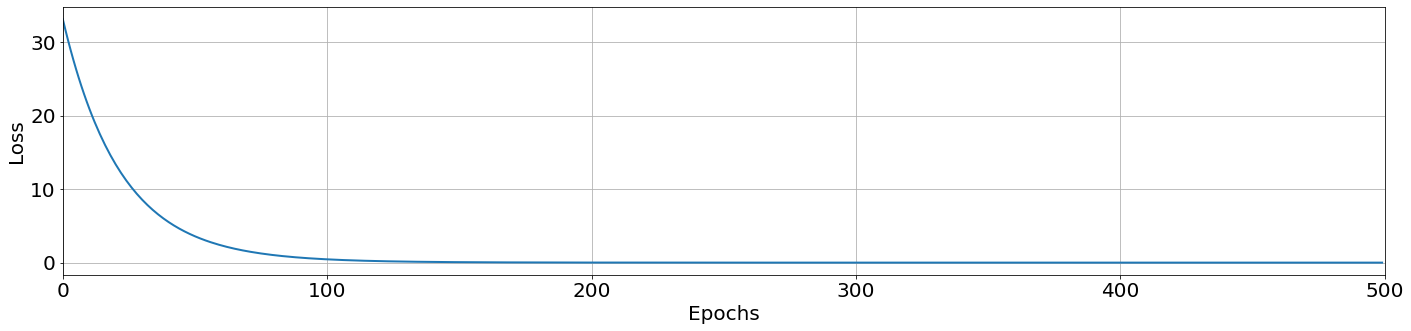

In [124]:
plt.rcParams['font.size'] = 20
plt.figure(1, figsize=(20,5))
plt.plot(np.arange(num_epochs), loss_values, linewidth=2)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, num_epochs)
plt.tight_layout()

## Conclusion

In future JAX-related posts, I'm planning on using it to build more sophisticated systems.  This might include solving concocted toy problems, implementing models from journal articles, or doing something new.  I realize there are plenty of fairly mature libraries out there that can do this sort of thing, but I'd rather implement software that I can customize to meet my needs.  Of course this doesn't mean that I won't read code and borrow ideas from other developers.